In [1]:
import pandas as pd

In [2]:
import seaborn as sns

In [3]:


def produce_feature(data):
    for window_size in [10, 60, 360]:
        # Precompute means for anglez
        anglez_mean = data['anglez'].rolling(window=window_size).mean()
        data[f'moving_average_anglez_{window_size}'] = anglez_mean
        data[f'variance_anglez_{window_size}'] = data['anglez'].rolling(window=window_size).var()
        # Optimized MSE calculation for anglez
        data[f'mse_anglez_{window_size}'] = ((data['anglez'] - anglez_mean) ** 2).rolling(window=window_size).mean()

        if 'enmo' in data.columns:
            # Precompute means for enmo
            enmo_mean = data['enmo'].rolling(window=window_size).mean()
            data[f'moving_average_enmo_{window_size}'] = enmo_mean
            data[f'variance_enmo_{window_size}'] = data['enmo'].rolling(window=window_size).var()
            # Optimized MSE calculation for enmo
            data[f'mse_enmo_{window_size}'] = ((data['enmo'] - enmo_mean) ** 2).rolling(window=window_size).mean()
    return data



In [4]:
def merge_event(Data2,Dataf):
    Data2['timestamp'] = pd.to_datetime(Data2['timestamp'])
    Dataf['timestamp'] = pd.to_datetime(Dataf['timestamp'], errors='coerce')


    Data2['state'] = 0


    last_valid_wakeup = None


    for night in sorted(Dataf['night'].unique()):
        night_data = Dataf[Dataf['night'] == night]
        onset_time = night_data[night_data['event'] == 'onset']['timestamp'].iloc[0]
        wakeup_time = night_data[night_data['event'] == 'wakeup']['timestamp'].iloc[0]

        if pd.isnull(onset_time) and last_valid_wakeup is not None:
            #
            next_night_data = Dataf[(Dataf['night'] > night) & (Dataf['event'] == 'onset') & pd.notnull(Dataf['timestamp'])]
            next_valid_onset_time = next_night_data['timestamp'].iloc[0] if not next_night_data.empty else None

            if next_valid_onset_time:
                Data2 = Data2.drop(Data2[(Data2['timestamp'] > last_valid_wakeup) & (Data2['timestamp'] < next_valid_onset_time)].index)

        if pd.notnull(wakeup_time):
            last_valid_wakeup = wakeup_time


    last_night_data = Dataf[Dataf['night'] == Dataf['night'].max()]
    last_onset_time = last_night_data[last_night_data['event'] == 'onset']['timestamp'].iloc[0]
    last_wakeup_time = last_night_data[last_night_data['event'] == 'wakeup']['timestamp'].iloc[0]
    if pd.isnull(last_wakeup_time) and last_valid_wakeup is not None:

        Data2 = Data2[Data2['timestamp'] <= last_valid_wakeup]


    for _, row in Dataf.iterrows():
        event = row['event']
        event_time = row['timestamp']

        if event == 'onset' and pd.notnull(event_time):
            # 查找对应的wakeup时间
            wakeup_time = Dataf[(Dataf['night'] == row['night']) & (Dataf['event'] == 'wakeup')]['timestamp'].iloc[0]
            if pd.notnull(wakeup_time):
                # 更新state为1
                Data2.loc[(Data2['timestamp'] >= event_time) & (Data2['timestamp'] <= wakeup_time), 'state'] = 1
    return Data2

In [5]:
!pip install pyarrow
data=pd.read_parquet('/content/train_series2.parquet')
data_062dbd4c95e6=data[data['series_id']=='062dbd4c95e6']

In [6]:
Dataf=pd.read_csv('train_events.csv')
Dataf.dropna(axis=0)
e_062dbd4c95e6=Dataf[Dataf['series_id']=='062dbd4c95e6']

In [7]:
Data2=data_062dbd4c95e6
Dataf=e_062dbd4c95e6

In [8]:
Data2=merge_event(Data2,Dataf)
produce_feature(Data2)

<ipython-input-4-5b796c7b1cf9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data2['timestamp'] = pd.to_datetime(Data2['timestamp'])
<ipython-input-4-5b796c7b1cf9>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data2['state'] = 0


,series_id,step,timestamp,anglez,enmo,state,moving_average_anglez_10,variance_anglez_10,mse_anglez_10,moving_average_enmo_10,...,mse_anglez_60,moving_average_enmo_60,variance_enmo_60,mse_enmo_60,moving_average_anglez_360,variance_anglez_360,mse_anglez_360,moving_average_enmo_360,variance_enmo_360,mse_enmo_360
2992140,062dbd4c95e6,0,2018-08-22 12:15:00-04:00,10.953900,0.0839,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2992141,062dbd4c95e6,1,2018-08-22 12:15:05-04:00,16.707899,0.0862,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2992142,062dbd4c95e6,2,2018-08-22 12:15:10-04:00,14.305600,0.0976,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2992143,062dbd4c95e6,3,2018-08-22 12:15:15-04:00,23.613001,0.0934,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2992144,062dbd4c95e6,4,2018-08-22 12:15:20-04:00,14.443400,0.1048,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3456380,062dbd4c95e6,464240,2018-09-18 09:01:40-04:00,39.358398,0.0228,1,55.767361,177.860078,153.202112,0.01519,...,41.261276,0.002532,0.000077,0.000075,42.024329,1900.602411,2221.096475,0.003746,0.00015,0.000152
3456381,062dbd4c95e6,464241,2018-09-18 09:01:45-04:00,39.316799,0.0000,1,53.074921,187.685332,172.130704,0.01519,...,51.453550,0.002532,0.000077,0.000075,41.934394,1898.162793,2215.772106,0.003746,0.00015,0.000152
3456382,062dbd4c95e6,464242,2018-09-18 09:01:50-04:00,39.316799,0.0000,1,50.382481,181.401173,184.375634,0.01519,...,61.279395,0.002532,0.000077,0.000075,41.844460,1895.706953,2210.498660,0.003746,0.00015,0.000152
3456383,062dbd4c95e6,464243,2018-09-18 09:01:55-04:00,39.316799,0.0000,1,47.690040,159.007603,191.386751,0.01519,...,70.745508,0.002532,0.000077,0.000075,41.754526,1893.234892,2205.275923,0.003746,0.00015,0.000152


In [9]:
Data2.dropna(inplace=True)

In [10]:
y=Data2['state']
X=Data2[[ 'step', 'moving_average_anglez_360', 'variance_anglez_360', 'mse_anglez_360',
       'moving_average_enmo_360', 'variance_enmo_360', 'mse_enmo_360']]

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


In [12]:
from sklearn.model_selection import train_test_split
from sklearn import svm
Data2.dropna(inplace=True)
X_train, X_test, y_train, y_test = train_test_split(
  X, y, test_size=0.2, random_state=42)


In [13]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)


In [14]:
clf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [15]:
y_pred = clf.predict(X_test)


In [16]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[18163,     2],
       [    5, 19318]])

In [17]:
accuracy = accuracy_score(y_test, y_pred)

In [18]:
accuracy

0.9998132735808792

In [19]:
X_test_with_pred = X_test.copy()
X_test_with_pred['predicted_label'] = y_pred

In [20]:
cluster_data=X_test_with_pred[['step','predicted_label']]

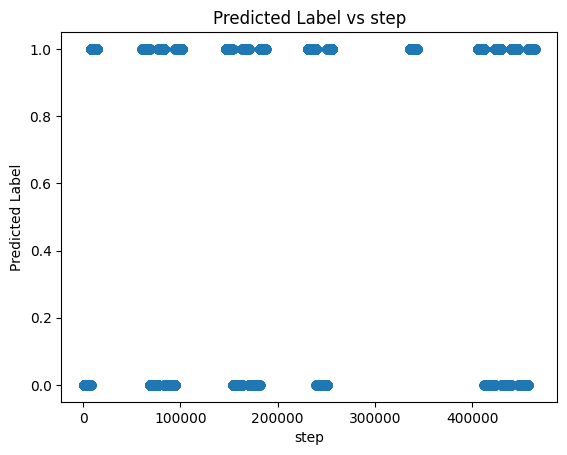

In [21]:
import matplotlib.pyplot as plt

plt.scatter(X_test_with_pred['step'], X_test_with_pred['predicted_label'])
plt.xlabel('step')
plt.ylabel('Predicted Label')
plt.title('Predicted Label vs ' + 'step')
plt.show()


In [22]:
cluster_data.iloc[1]['step']

61954

In [23]:
from sklearn.cluster import DBSCAN
import numpy as np

eps = 35
min_samples = 7
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan.fit(cluster_data)


core_samples_mask = np.zeros_like(dbscan.labels_, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True

border_points = []

for i in range(len(cluster_data)):
    if not core_samples_mask[i] and (dbscan.labels_[i] != -1):

        border_points.append(cluster_data.iloc[i]['step'])


border_points_times = np.array(border_points).flatten()


In [24]:
border_points_times.sort()

In [25]:
def find_stable_boundaries(cluster_data, min_consecutive_steps=10):
    stable_change_points_steps = []
    current_label = cluster_data['predicted_label'].iloc[0]
    change_count = 0

    for i in range(1, len(cluster_data)):
        if cluster_data['predicted_label'].iloc[i] != current_label:
            change_count += 1
        else:
            if change_count >= min_consecutive_steps:
                stable_change_points_steps.append(cluster_data['step'].iloc[i - change_count])
            change_count = 0
            current_label = cluster_data['predicted_label'].iloc[i]

    if change_count >= min_consecutive_steps:
        stable_change_points_steps.append(cluster_data['step'].iloc[-change_count])

    return stable_change_points_steps

min_consecutive_steps = 5

stable_boundary_steps = find_stable_boundaries(cluster_data, min_consecutive_steps)
print(stable_boundary_steps)


[2129, 431087, 248016, 85511, 86010, 435529, 2980, 448539, 454608, 175049, 432810, 242099, 3959, 2107, 71430, 456927, 241018, 430632, 157694, 69828, 421501, 156353, 4939, 170756, 173736, 412622, 158945, 243694, 456506, 76888, 449546, 421863, 170626, 248074, 179831, 438973, 5916, 248253, 415660, 414349, 160104, 88423, 430715, 455164, 448580, 6698, 176816, 450576, 4750, 414847, 447453, 76141, 158852, 240434, 88950, 172347, 71578, 417144, 175396, 452497, 421059, 89807, 242620, 91584, 435374, 239821, 72492, 421124, 436755, 71500, 414988, 91240, 69914, 5855, 92942, 176429, 455259, 454707, 89015, 155554, 161119, 156520, 155372, 452436, 248959, 417204, 74970, 83448, 92445, 154232, 154983, 162899, 455625, 176689, 163324, 76184, 73284, 75952, 243011, 157300, 454099, 162509, 90415, 160165, 241479, 156843, 452501, 5338, 455448, 154199, 69002, 161286, 435148, 161763, 418444, 86935, 433886, 419124, 420692, 162009, 74123, 70438, 248188, 76677, 413876, 436863, 456553, 87183, 7742, 413624, 84240, 8875

In [26]:
border_points_times

array([  1474,   5659,   5679,   6626,   9799,   9810,   9826,  12135,
        12143,  13148,  14483,  60732,  62416,  62419,  62423,  69994,
        70370,  70373,  73030,  73033,  76363,  76366,  76376,  76387,
        83158,  83164,  87603,  90110,  91988,  92622,  98916,  98931,
       101861, 101869, 146520, 148120, 148154, 148163, 148688, 148691,
       148815, 152821, 152824, 157624, 158764, 158769, 163584, 165437,
       165441, 172030, 173203, 173219, 173256, 173259, 178074, 187631,
       187636, 187638, 187642, 237520, 237522, 237525, 237548, 237556,
       239878, 239904, 240191, 250396, 252927, 252929, 335933, 335937,
       413270, 413281, 413828, 413830, 413835, 413836, 414486, 416122,
       416136, 416137, 416141, 416782, 416800, 423648, 427684, 427689,
       429373, 434543, 434681, 434683, 443046, 443050, 447467, 447492,
       449849, 449899, 452277, 457908, 457926, 457952, 463166, 463168,
       463177])

In [27]:
border_points_times.ndim

1

In [28]:
border_points_times=border_points_times.tolist()

In [29]:
# Call the function and print the 'step' values at stable boundaries
stable_boundary_steps = find_stable_boundaries(cluster_data,7)
stable_boundary_steps.sort()
print(stable_boundary_steps)

[2107, 2129, 2198, 3049, 3559, 4075, 4939, 7742, 69186, 69828, 70164, 70188, 70565, 71149, 71430, 71500, 71800, 72653, 73681, 73894, 74970, 75730, 76888, 83956, 84588, 84912, 85260, 86010, 86935, 88088, 88505, 88752, 89147, 89449, 90514, 91372, 91432, 91584, 91587, 91659, 91919, 92160, 93001, 153630, 153962, 156287, 156353, 156465, 157018, 157300, 158341, 158945, 161016, 162009, 162131, 163324, 170246, 170561, 170626, 170976, 171236, 172326, 174419, 174456, 175049, 175396, 175871, 176938, 177068, 177558, 178327, 179923, 181359, 240895, 241057, 242891, 244237, 248016, 249811, 249886, 250126, 412622, 412812, 413624, 414695, 414914, 417204, 417864, 419842, 419862, 421515, 422839, 422956, 430104, 430161, 430632, 430715, 431087, 431703, 431976, 432613, 432630, 432810, 433999, 435529, 436116, 436196, 436228, 436863, 437860, 439408, 447783, 448241, 448714, 449704, 452042, 452138, 453036, 453258, 453340, 453958, 454273, 455233, 456262, 456851, 456927]


In [30]:
a=e_062dbd4c95e6.dropna(axis=0)['step']

In [31]:
def cusum(data, threshold=1, drift=0):
    """
    CUSUM Algorithm to detect changes in the mean.
    """
    S_pos, S_neg = [0], [0]
    change_points = []

    for i in range(1, len(data)):
        S_pos.append(max(0, S_pos[-1] + data[i] - (threshold + drift)))
        S_neg.append(min(0, S_neg[-1] + data[i] - (-threshold + drift)))
        if S_pos[-1] > threshold or S_neg[-1] < -threshold:
            change_points.append(i)
            S_pos[-1] = 0
            S_neg[-1] = 0

    return change_points



In [32]:
! pip install Rbeast


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 8.4 MB/s eta 0:00:00


In [33]:
cluster_data_sort=cluster_data.iloc[0:2000,:].sort_values(by='step')

In [34]:
import Rbeast as rb

In [35]:
cluster_data_sort['predicted_label']

2992870    0
2993096    0
2993209    0
2993407    0
2993558    0
          ..
3455619    1
3455626    1
3456074    1
3456114    1
3456129    1
Name: predicted_label, Length: 2000, dtype: int64

In [36]:
cluster_data_sort

,step,predicted_label
2992870,730,0
2993096,956,0
2993209,1069,0
2993407,1267,0
2993558,1418,0
...,...,...
3455619,463479,1
3455626,463486,1
3456074,463934,1
3456114,463974,1


In [37]:
pelt=cluster_data_sort.iloc[[70, 195, 300, 370, 485, 630, 745, 840, 945, 1090, 1200, 1415, 1535, 1610, 1725, 1815, 1930, 1999]
]

In [38]:
!pip install ruptures


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 6.5 MB/s eta 0:00:00


In [39]:
np_data=cluster_data_sort['predicted_label'].to_numpy()

In [40]:
np_data

array([0, 0, 0, ..., 1, 1, 1])

In [41]:
import ruptures as rpt

In [42]:
model = "l2"  # "l1", "rbf", etc.
algo = rpt.Pelt(model=model).fit(np_data)


result = algo.predict(pen=10)


print(result)

[70, 195, 300, 370, 485, 630, 745, 840, 945, 1090, 1200, 1415, 1535, 1610, 1725, 1815, 1930, 2000]


In [43]:
algo_window=rpt.Window(width=30, model=model).fit(np_data)

In [44]:
help(rb.beast)


Help on function beast in module Rbeast.beast:

beast(Y, start=1, deltat=1, season='harmonic', period=nan, scp_minmax=[0, 10], sorder_minmax=[0, 5], sseg_minlength=None, sseg_leftmargin=None, sseg_rightmargin=None, tcp_minmax=[0, 10], torder_minmax=[0, 1], tseg_minlength=None, tseg_leftmargin=None, tseg_rightmargin=None, method='bayes', detrend=False, deseasonalize=False, mcmc_seed=0, mcmc_burbin=200, mcmc_chains=3, mcmc_thin=5, mcmc_samples=8000, ci=False, precValue=1.5, precPriorType='componentwise', print_options=True, print_progress=True, quiet=False, hasOutlier=False, ocp_max=10, gui=False, **kwargs)
          
    ################################################################################################
     Bayesian changepoint detection and time series decomposition for regular or irregular time series data
        
       The fitted model is:
             Y= trend + error             if data has no periodic/seasonal variation (i.e., season='none')
         Y= trend + sea

In [45]:
o = rb.beast( cluster_data_sort['predicted_label'], season='none')
rb.print(o)


INFO: To supress printing the parameers in beast(),      set print.options = 0 
INFO: To supress printing the parameers in beast_irreg(),set print.options = 0 
INFO: To supress printing the parameers in beast123(),   set extra.printOptions = 0  
INFO: To supress warning messages in beast(),            set quiet = 1 
INFO: To supress warning messages in beast_irreg(),      set quiet = 1 
INFO: To supress warning messages in beast123(),         set extra.quiet = 1  

#--------------------------------------------------#
#       Brief summary of Input Data                #
#--------------------------------------------------#
Data Dimension: One signal of length 2000
IsOrdered     : Yes, ordered in time
IsRegular     : Yes, evenly spaced at interval of  1 (unknown unit)
hasSeasonCmpnt: False | no periodic or seasonal component. The model Y=Trend+Error is fitted.
HasOutlierCmpt: False | If true, Y=Trend+Outlier+Error (experimental) is fitted instead of Y=Trend+Error 
Detrend       : False |

In [46]:
o['trend']['cp']

Object of 9 field(s):

 time        : [2000 float32] 
 data        : [2000 float32] 
 marg_lik    : -5772.26 
 R2          : 0.841263 
 RMSE        : 0.214405 
 sig2        : 0.0761881 
 trend       : [ 1 object with 19 fields] 
               ncp            : 9.99942 
               ncp_median     : 10 
               ncp_mode       : 10 
               ncp_pct90      : 10 
               ncp_pct10      : 10 
               ncpPr          : [11 float32] 
               cpOccPr        : [2000 float32] 
               order          : [2000 float32] 
               cp             : [10 float32] 
               cpPr           : [10 float32] 
               cpAbruptChange : [10 float32] 
               cpCI           : [10x2 float32] 
               Y              : [2000 float32] 
               SD             : [2000 float32] 
               CI             : [2000x2 float32] 
               slp            : [2000 float32] 
               slpSD          : [2000 float32] 
               s

In [47]:
b=cluster_data_sort.iloc[[373,198,69,632,1199,1092,1610,1537,945,303]]['step'].to_list()

In [48]:
pelt

,step,predicted_label
3000382,8242,1
3060406,68266,1
3069370,77230,0
3075232,83092,1
3086937,94797,1
3145678,153538,1
3155811,163671,1
3162969,170829,0
3173724,181584,1
3231643,239503,1


In [49]:
ground_truth=a.to_list()

In [50]:
ground_truth

[7872.0,
 14484.0,
 60720.0,
 68400.0,
 77304.0,
 83292.0,
 94716.0,
 101976.0,
 146520.0,
 153576.0,
 163500.0,
 170244.0,
 181452.0,
 187644.0,
 230892.0,
 239532.0,
 250848.0,
 256224.0,
 335916.0,
 343164.0,
 405540.0,
 412416.0,
 423240.0,
 429924.0,
 439812.0,
 447384.0,
 457284.0,
 464244.0]

In [51]:
def match_with_tolerance(detected, true, tolerance):
    """
    Match detected change points with true change points within a tolerance.
    Returns lists of matched and unmatched detected and true points.
    """
    matched_detected = []
    unmatched_detected = detected.copy()
    unmatched_true = true.copy()

    for d in detected:
        matched = False
        for t in true:
            if abs(t - d) <= tolerance:
                matched_detected.append(d)
                if d in unmatched_detected:
                    unmatched_detected.remove(d)
                if t in unmatched_true:
                    unmatched_true.remove(t)
                matched = True
                break
        if not matched:
            unmatched_detected.append(d)

    return matched_detected, unmatched_detected, unmatched_true



In [52]:

tolerance = 400
def metric(predicted, truth):
    matched_detected, unmatched_detected, unmatched_true = match_with_tolerance(predicted, truth, tolerance)

    # True Positives (TP), False Positives (FP), and False Negatives (FN)
    tp = len(matched_detected)
    fp = len(unmatched_detected)
    fn = len(unmatched_true)

    # Precision, Recall, F1 Score
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"Precision: {precision}, Recall: {recall}, F1 Score: {f1_score}")

In [53]:
metric(b,ground_truth)

Precision: 0.8181818181818182, Recall: 0.32142857142857145, F1 Score: 0.46153846153846156


In [54]:
metric(stable_boundary_steps,ground_truth)

Precision: 0.06329113924050633, Recall: 0.45454545454545453, F1 Score: 0.11111111111111112


In [55]:
metric(border_points_times,ground_truth)

Precision: 0.09375, Recall: 0.5, F1 Score: 0.15789473684210525
